# COVID-19 Effect on Mortality and Fertility in Orange County, California

### Motivation  
The datafication of the pandemic has allowed the public access to more health-related data at a granular level than ever before. The county that I was assigned, Orange County, California,  had quite a high number of cases given the high population of the county. The lockdowns and mask mandates enforced did prevent people from leaving their homes and the spread of other diseases like the flu, and likely even other kinds of death. However, at the same time, with hospitals being overloaded and sometimes even needing to turn away patients, I wonder how many deaths there were in excess of what is typical to see in Orange County as this may provide evidence that there were actually more COVID-related deaths than is officially being reported, since the healthcare industry may not want to use tests on already deceased persons. Essentially, this question will help answer if we can be certain that there were more deaths due to the pandemic than what the “official” count may suggest, or if the pandemic reduced other causes of death such as from accidents.  

Another angle here is that COVID added a lot of uncertainty to the world. This had many adverse effects on people’s lives, and I am curious to see how this affected fertility. Perhaps during these stressful times, fewer people were confident in the future and their ability to support a child, or perhaps quarantine gave people the opportunity to move forward with their family planning because of the flexibility that working from home provided. I would like to inspect the pandemic and its effects on the lives of people in Orange County, CA from the angle of effect on mortality and fertility.  

### Hypothesis  
My hypothesis related to mortality is that all-cause mortality was higher during the pandemic than pre-pandemic, indicating that there were more deaths due to COVID-19 than were being reported. My hypothesis relating to fertility is that there were fewer births during the pandemic compared to pre-pandemic due to the stress and uncertainty it caused.  

### Data  
- The RAW_us_confirmed_cases.csv file from the [Kaggle repository of John Hopkins University COVID-19 data.](https://www.kaggle.com/antgoldbloom/covid19-data-from-john-hopkins-university?select=RAW_us_confirmed_cases.csv)  
- The RAW_us_deaths.csv file from the [Kaggle repository of John Hopkins University COVID-19 data.](https://www.kaggle.com/antgoldbloom/covid19-data-from-john-hopkins-university?select=RAW_us_deaths.csv)  
- Deaths from [California Health & Human Services Department](https://data.chhs.ca.gov/dataset/death-profiles-by-county/resource/2e546f88-bba8-4d77-846a-7fb77846cac6)  
- Births from [California Health & Human Services Department](https://data.chhs.ca.gov/dataset/live-birth-profiles-by-county/resource/94a186da-7184-427b-b0b5-224bb0a05cd8)

In [1]:
# Set up file
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Show all columns
pd.set_option('display.max_columns', None)

# Set filepaths
RAW_DATA_PATH = '../data_raw/'
CLEAN_DATA_PATH = '../data_clean/'
RESULTS_PATH = '../results/'

## Import COVID-19 Data from Johns Hopkins  
Import the data, pre-downloaded from the Johns Hopkins Kaggle page, and prepare it to be joined with the CHHS data. This means:  
- Create a datetime index on the 'date' columns
- Filter out unnecessary columns like `Lat`, `Long_`, etc. and only keep the necessary columns for analysis: `Province_State`, `Admin2`, `date`, and `cases` or `covid_deaths`.
- Join these data sets together on the `FIPS` and `date` column.
- Filter on just the data from Orange County, California
- Aggregate the data from daily to monthly

In [2]:
# Import data assuming we are in src folder
cases_raw = pd.read_csv(os.path.join(RAW_DATA_PATH, 'RAW_us_confirmed_cases.csv/RAW_us_confirmed_cases.csv'))
covid_deaths_raw = pd.read_csv(os.path.join(RAW_DATA_PATH, 'RAW_us_deaths.csv'))

# identify Orange County, CA FIPs code
fip = cases_raw.loc[(cases_raw['Province_State'] == 'California') & (cases_raw['Admin2'] == 'Orange'), 'FIPS'].values[0]
print("Orange County FIP: ", str(fip))

# Pivot cases and deaths data to long format
cases = pd.melt(cases_raw, id_vars = cases_raw.columns[0:11], var_name = 'date', value_name = 'cum_cases')
cases['date'] = pd.to_datetime(cases['date'], format = '%m/%d/%y')
cases = cases.loc[:, ['Province_State', 'Admin2', 'FIPS', 'date', 'cum_cases']]
covid_deaths = pd.melt(covid_deaths_raw, id_vars = covid_deaths_raw.columns[0:12], var_name = 'date', value_name = 'cum_covid_deaths')
covid_deaths['date'] = pd.to_datetime(covid_deaths['date'], format = '%m/%d/%y')
# Drop common columns from covid_deaths
covid_deaths = covid_deaths.loc[:, ['FIPS', 'Population', 'date', 'cum_covid_deaths']]

# Print column names
print(cases.columns)
print(covid_deaths.columns)

Orange County FIP:  6059.0
Index(['Province_State', 'Admin2', 'FIPS', 'date', 'cum_cases'], dtype='object')
Index(['FIPS', 'Population', 'date', 'cum_covid_deaths'], dtype='object')


In [3]:
# Combine cases and deaths into one df
covid_df = cases.merge(covid_deaths, how = 'outer', on = ['FIPS', 'date'])
covid_df.to_csv(os.path.join(CLEAN_DATA_PATH, 'us_covid_cases-deaths.csv'), index = False)
covid_df.set_index('date', inplace = True)

In [4]:
# Aggregate data to monthly level instead of daily level to match granularity from CHHS data
# Get just Orange County data
covid = covid_df.loc[covid_df['FIPS'] == fip, ]\
    .sort_values(by = ['date'])
# Get daily new cases and deaths
covid['cases'] = covid['cum_cases'].diff(periods = 1)
covid['covid_deaths'] = covid['cum_covid_deaths'].diff(periods = 1)
covid = covid.groupby([pd.Grouper(freq='MS'), 'FIPS', 'Province_State', 'Admin2'])\
    .agg({'cases': np.sum, 'covid_deaths': np.sum})\
    .reset_index()
covid

,date,FIPS,Province_State,Admin2,cases,covid_deaths
0,2020-01-01,6059.0,California,Orange,1.0,0.0
1,2020-02-01,6059.0,California,Orange,0.0,0.0
2,2020-03-01,6059.0,California,Orange,501.0,7.0
3,2020-04-01,6059.0,California,Orange,2438.0,38.0
4,2020-05-01,6059.0,California,Orange,4289.0,102.0
5,2020-06-01,6059.0,California,Orange,14830.0,193.0
6,2020-07-01,6059.0,California,Orange,20787.0,278.0
7,2020-08-01,6059.0,California,Orange,7789.0,362.0
8,2020-09-01,6059.0,California,Orange,5711.0,288.0
9,2020-10-01,6059.0,California,Orange,6851.0,215.0


## Import data from California's Department of Health & Human Services  

### Deaths
Import the data, extract the necessary types of deaths and strata, and create a date column to prepare it for merging with Johns Hopkins' data:  
- Union the disparate data sets to have one dataset with all data
- Drop unnecessary columns `Geography_Type`, `Strata`, `Strata_Name`, `Data_Extract_Date`, `Annotation_Code`, `Annotation_Desc`, `Cause`
- Keep only `Total Population` strata, and filter to just all cause death, injuries, and suicides. Since COVID data is not stratified, we cannot use the stratified CHHS data.
- Pivot the data to have a separate column for each kind of cause of death

In [5]:
# Get data from CHHS of deaths and drop extract date column
deaths_2021 = pd.read_csv('https://data.chhs.ca.gov/dataset/58619b69-b3cb-41a7-8bfc-fc3a524a9dd4/resource/2e546f88-bba8-4d77-846a-7fb77846cac6/download/2021-11_deaths_provisional_county_month_sup.csv')
deaths_19_20 = pd.read_csv('https://data.chhs.ca.gov/dataset/58619b69-b3cb-41a7-8bfc-fc3a524a9dd4/resource/078185a9-e3a7-403f-a546-b8c582f0a9d8/download/2021-11-29_deaths_final_2019-2020_occurrence_county_month_sup.csv')
deaths_14_18 = pd.read_csv('https://data.chhs.ca.gov/dataset/58619b69-b3cb-41a7-8bfc-fc3a524a9dd4/resource/1a69fe2d-9796-49de-be51-1949d09b242a/download/2021-11-29_deaths_final_2014-2018_occurrence_county_month_sup.csv')
deaths_chhs = pd.concat([deaths_2021, deaths_19_20, deaths_14_18], join = 'outer')

# Drop useless columns
# Filter strata for "Total Population"
# Filter for Orange County
# Filter for All causes (total), Accidents (unintentional injuries), Intentional self-harm (suicide)
deaths_chhs = deaths_chhs.loc[(deaths_chhs['Strata'] == 'Total Population') & 
                              (deaths_chhs['County'] == 'Orange') & 
                              (deaths_chhs['Cause'].isin(['ALL', 'INJ', 'SUI'])), ]\
    .drop(['Geography_Type', 'Strata', 'Strata_Name', 'Data_Extract_Date', 'Annotation_Code', 'Annotation_Desc', 'Cause'], axis = 1)

In [6]:
# Create new date column to join on
deaths_chhs['date'] = pd.to_datetime(deaths_chhs['Year'].astype(str) + '/' + deaths_chhs['Month'].astype(str) + '/01',
                                   format = '%Y/%m/%d')
deaths_chhs.drop(['Year', 'Month'], axis = 1, inplace = True)

# Pivot the data from long to wide
deaths_chhs = deaths_chhs.pivot(index = ['County', 'date'], columns = 'Cause_Desc', values = 'Count').reset_index()
deaths_chhs

Cause_Desc,County,date,Accidents (unintentional injuries),All causes (total),Intentional self-harm (suicide)
0,Orange,2014-01-01,60.0,1798.0,38.0
1,Orange,2014-02-01,62.0,1513.0,19.0
2,Orange,2014-03-01,78.0,1668.0,22.0
3,Orange,2014-04-01,60.0,1589.0,21.0
4,Orange,2014-05-01,58.0,1571.0,23.0
...,...,...,...,...,...
89,Orange,2021-06-01,105.0,1750.0,25.0
90,Orange,2021-07-01,85.0,1864.0,17.0
91,Orange,2021-08-01,58.0,2085.0,16.0
92,Orange,2021-09-01,49.0,2020.0,19.0


### Births  

In [7]:
births_21 = pd.read_csv('https://data.chhs.ca.gov/dataset/bc59b3db-3936-4c9b-9275-c5f4b3dc9023/resource/94a186da-7184-427b-b0b5-224bb0a05cd8/download/2021-11_births_provisional_county_month_sup.csv')
births_60 = pd.read_csv('https://data.chhs.ca.gov/dataset/bc59b3db-3936-4c9b-9275-c5f4b3dc9023/resource/d6c30e46-8618-407a-ba5a-bae308f86a1c/download/2021-10-18_births_final_county_month_sup.csv')
births_chhs = pd.concat([births_21, births_60], join = 'outer')

In [8]:
# Drop useless columns
# Filter strata for "Total Population"
# Filter for Orange County
# Filter for All causes (total), Accidents (unintentional injuries), Intentional self-harm (suicide)
births_chhs = births_chhs.loc[(births_chhs['Strata'] == 'Total Population') & 
                              (births_chhs['County'] == 'Orange') & 
                              (births_chhs['Geography_Type'] == 'Occurrence') & 
                              (births_chhs['Year'] > 2013), ]\
    .drop(['Geography_Type', 'Strata', 'Strata_Name', 'Data_Extract_Date', 'Annotation_Code', 'Annotation_Desc', ], axis = 1)

In [9]:
# Create new date column to join on
births_chhs['date'] = pd.to_datetime(births_chhs['Year'].astype(str) + '/' + births_chhs['Month'].astype(str) + '/01',
                                   format = '%Y/%m/%d')
births_chhs.drop(['Year', 'Month'], axis = 1, inplace = True)
births_chhs.rename({'Count': 'births'}, axis = 1, inplace = True)
births_chhs

,County,births,date
145,Orange,2478.0,2021-01-01
435,Orange,2418.0,2021-02-01
725,Orange,2700.0,2021-03-01
1015,Orange,2665.0,2021-04-01
1305,Orange,2753.0,2021-05-01
...,...,...,...
98861,Orange,2886.0,2020-08-01
99441,Orange,2862.0,2020-09-01
100021,Orange,2784.0,2020-10-01
100601,Orange,2606.0,2020-11-01


## Merge Data  
Merge the three data sets together, clean up the column names, and add information for analysis.  
- Truncate accidents and suicides data to June 2021 due to data issues

In [10]:
TRUNC_DATE = '2021-06-01'

oc_df = deaths_chhs.merge(births_chhs, how = 'inner', on = ['County', 'date'])\
    .merge(covid[['date', 'cases', 'covid_deaths']], how = 'left', on = ['date'])\
    .rename({'Accidents (unintentional injuries)': 'accidents',
             'All causes (total)': 'total_deaths',
             'Intentional self-harm (suicide)': 'suicide'},
            axis = 1)\
    .drop(['County'], axis = 1)
oc_df['pandemic'] = oc_df['date'] >= '2020-03-01'
oc_df['non_covid_deaths'] = np.where(oc_df['covid_deaths'].isna(), oc_df['total_deaths'], oc_df['total_deaths'] - oc_df['covid_deaths'])
oc_df['accidents'] = np.where(oc_df['date'] > TRUNC_DATE, np.nan, oc_df['accidents'])
oc_df['suicide'] = np.where(oc_df['date'] > TRUNC_DATE, np.nan, oc_df['suicide'])
# TODO: ADD NON-COVID DEATHS
oc_df.to_csv(os.path.join(CLEAN_DATA_PATH, 'oc_cases-births-deaths.csv'), index = False)
oc_df

,date,accidents,total_deaths,suicide,births,cases,covid_deaths,pandemic,non_covid_deaths
0,2014-01-01,60.0,1798.0,38.0,3307.0,NaN,NaN,False,1798.0
1,2014-02-01,62.0,1513.0,19.0,3140.0,NaN,NaN,False,1513.0
2,2014-03-01,78.0,1668.0,22.0,3392.0,NaN,NaN,False,1668.0
3,2014-04-01,60.0,1589.0,21.0,3314.0,NaN,NaN,False,1589.0
4,2014-05-01,58.0,1571.0,23.0,3365.0,NaN,NaN,False,1571.0
...,...,...,...,...,...,...,...,...,...
89,2021-06-01,105.0,1750.0,25.0,2916.0,1467.0,59.0,True,1691.0
90,2021-07-01,NaN,1864.0,NaN,2897.0,8865.0,20.0,True,1844.0
91,2021-08-01,NaN,2085.0,NaN,2969.0,22984.0,81.0,True,2004.0
92,2021-09-01,NaN,2020.0,NaN,2910.0,13722.0,207.0,True,1813.0


In [11]:
oc_df.loc[oc_df['date'] > '2021-01-01', ['date', 'accidents', 'suicide']]

,date,accidents,suicide
85,2021-02-01,115.0,36.0
86,2021-03-01,125.0,27.0
87,2021-04-01,119.0,29.0
88,2021-05-01,121.0,40.0
89,2021-06-01,105.0,25.0
90,2021-07-01,NaN,NaN
91,2021-08-01,NaN,NaN
92,2021-09-01,NaN,NaN
93,2021-10-01,NaN,NaN


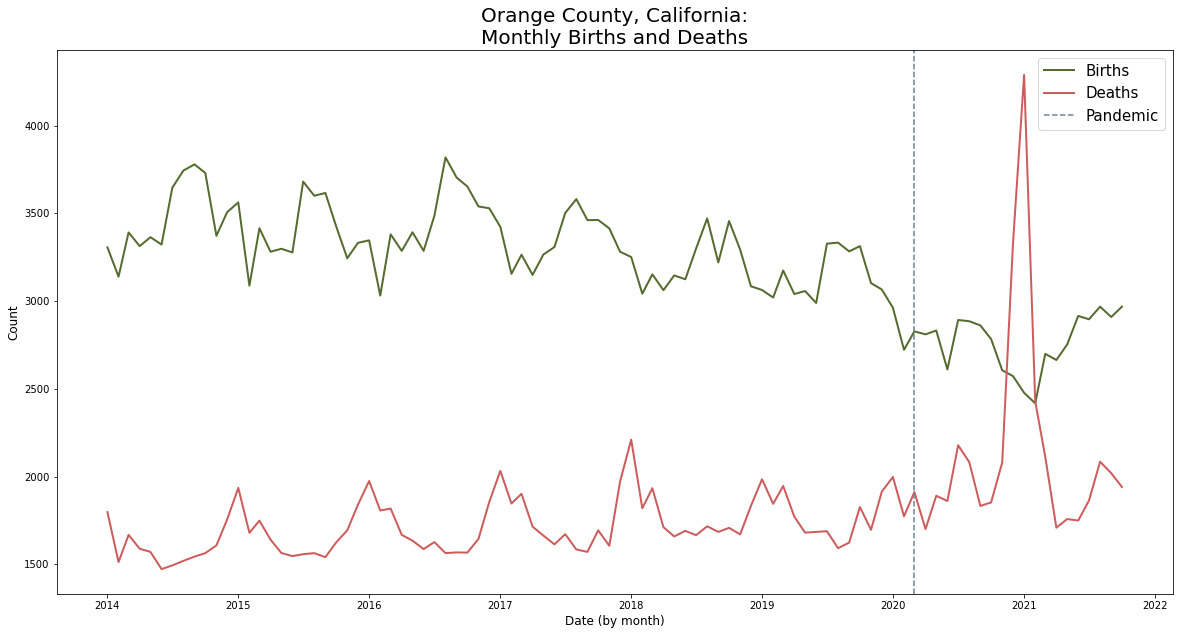

In [12]:
fig = plt.figure(figsize = (20, 10))
plt.plot(oc_df['date'], oc_df['births'], label = 'Births', c = 'darkolivegreen', linewidth = 2)
plt.plot(oc_df['date'], oc_df['total_deaths'], label = 'Deaths', c = 'indianred', linewidth = 2)
plt.axvline(x=pd.to_datetime('2020/03/01', format='%Y/%m/%d'), c = 'slategray', linestyle = '--', label = 'Pandemic')
plt.xlabel('Date (by month)', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.title('Orange County, California:\nMonthly Births and Deaths', fontsize = 20)
plt.legend(fontsize = 15)

# Save figure into the results folder
plt.savefig(os.path.join(RESULTS_PATH, 'oc_unadjusted_fertility-all-deaths.jpg'))

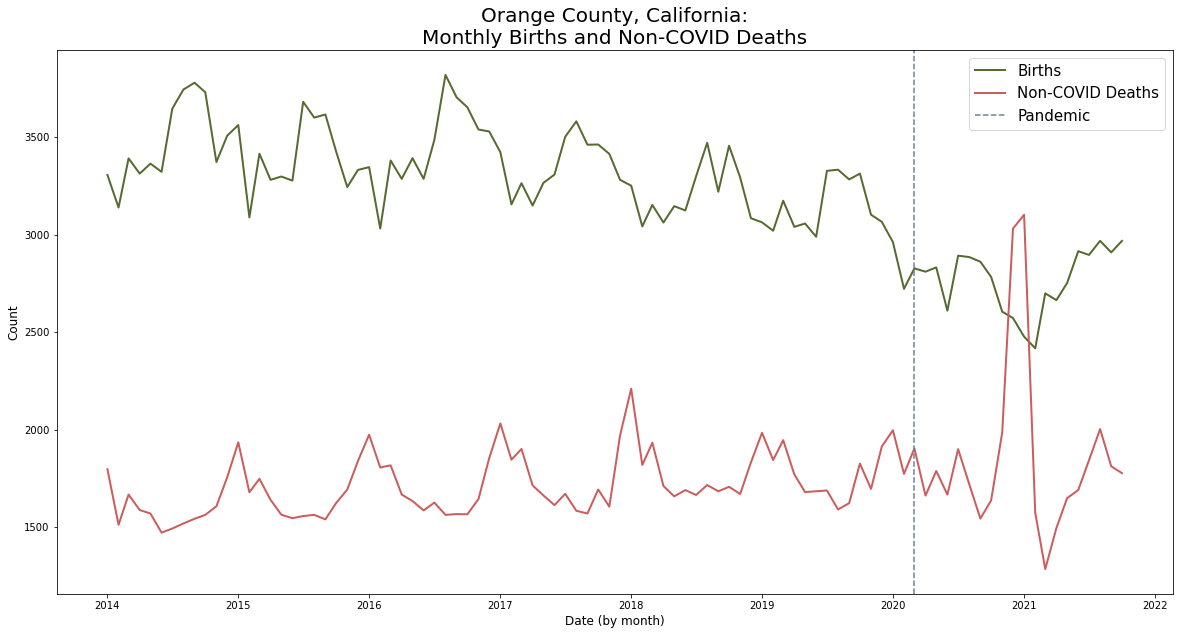

In [13]:
fig = plt.figure(figsize = (20, 10))
plt.plot(oc_df['date'], oc_df['births'], label = 'Births', c = 'darkolivegreen', linewidth = 2)
plt.plot(oc_df['date'], oc_df['non_covid_deaths'], label = 'Non-COVID Deaths', c = 'indianred', linewidth = 2)
plt.axvline(x=pd.to_datetime('2020/03/01', format='%Y/%m/%d'), c = 'slategray', linestyle = '--', label = 'Pandemic')
plt.xlabel('Date (by month)', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.title('Orange County, California:\nMonthly Births and Non-COVID Deaths', fontsize = 20)
plt.legend(fontsize = 15)

# Save figure into the results folder
plt.savefig(os.path.join(RESULTS_PATH, 'oc_unadjusted_fertility-non-covid-deaths.jpg'))

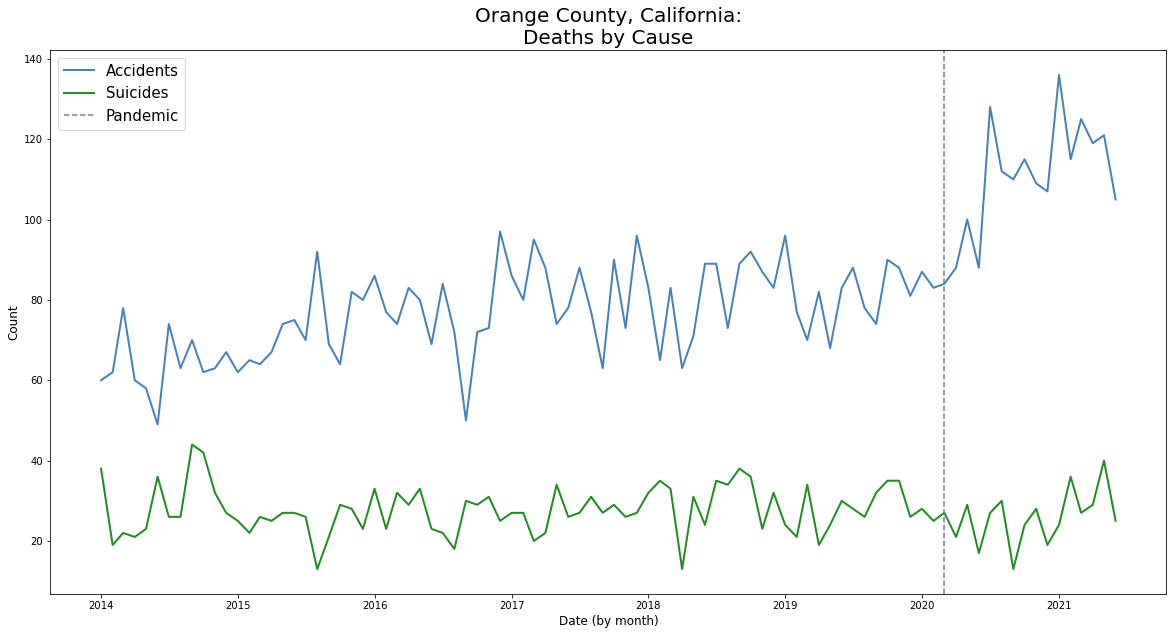

In [14]:
fig = plt.figure(figsize = (20, 10))
plt.plot(oc_df['date'], oc_df['accidents'], label = 'Accidents', c = 'steelblue', linewidth = 2)
plt.plot(oc_df['date'], oc_df['suicide'], label = 'Suicides', c = 'forestgreen', linewidth = 2)
plt.axvline(x=pd.to_datetime('2020/03/01', format='%Y/%m/%d'), c = 'slategray', linestyle = '--', label = 'Pandemic')
plt.xlabel('Date (by month)', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.title('Orange County, California:\nDeaths by Cause', fontsize = 20)
plt.legend(fontsize = 15)

# Save figure into the results folder
plt.savefig(os.path.join(RESULTS_PATH, 'oc_accidents-suicides.jpg'))

## Seasonally adjust births and deaths  
### Deaths

In [15]:
# TODO: Seasonal adjustments
oc_df.set_index('date', inplace = True)
oc_df = oc_df.asfreq('MS')

In [16]:
sa_deaths = sm.tsa.seasonal_decompose(oc_df.non_covid_deaths, model = 'multiplicative')

# Extract the trend and seasonal components
deaths_trend = sa_deaths.trend
deaths_seasonal = sa_deaths.seasonal

# Construct the seasonally adjusted series
deaths_adjusted = (oc_df.non_covid_deaths / sa_deaths.seasonal).rename('sa_deaths')

In [17]:
deaths_seasonal.loc[deaths_seasonal > 0]

date
2014-01-01    1.241730
2014-02-01    1.009851
2014-03-01    1.025618
2014-04-01    0.950965
2014-05-01    0.960980
                ...   
2021-06-01    0.935707
2021-07-01    0.953415
2021-08-01    0.922788
2021-09-01    0.909621
2021-10-01    0.954725
Freq: MS, Name: seasonal, Length: 94, dtype: float64

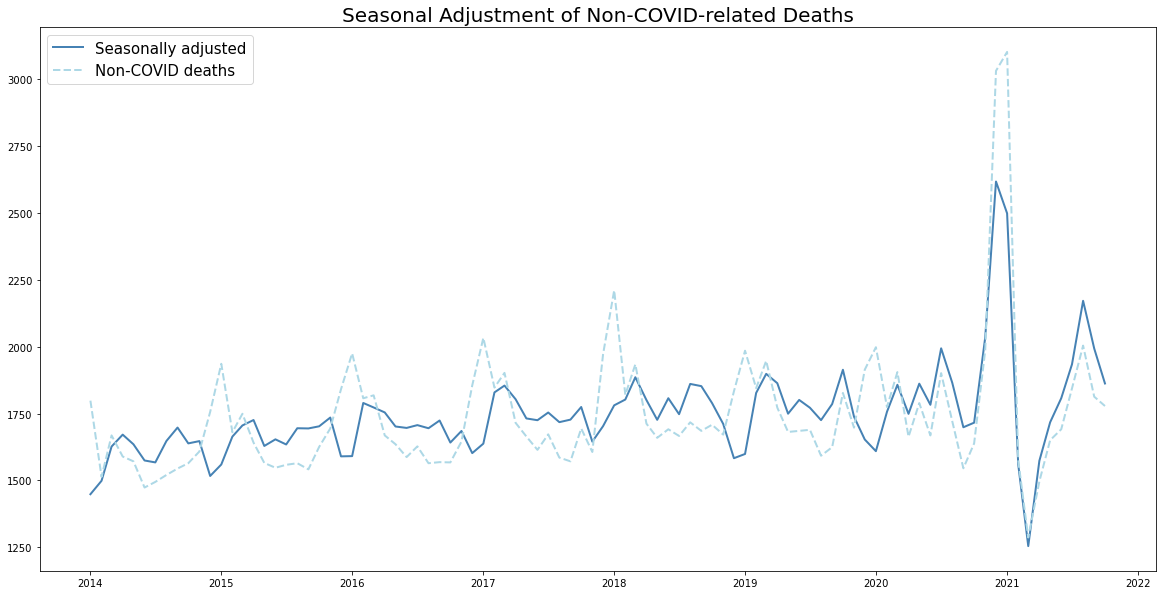

In [18]:
fig = plt.figure(figsize = (20, 10))
plt.plot(deaths_adjusted, c = 'steelblue', label = 'Seasonally adjusted', linewidth = 2)
plt.plot(oc_df['non_covid_deaths'], c = 'lightblue', label = 'Non-COVID deaths', linewidth = 2, linestyle = '--')
plt.title('Seasonal Adjustment of Non-COVID-related Deaths', fontsize = 20)
plt.legend(fontsize = 15)

# Save figure into the results folder
plt.savefig(os.path.join(RESULTS_PATH, 'deaths_seasonal-adjustment.jpg'))

### Births  

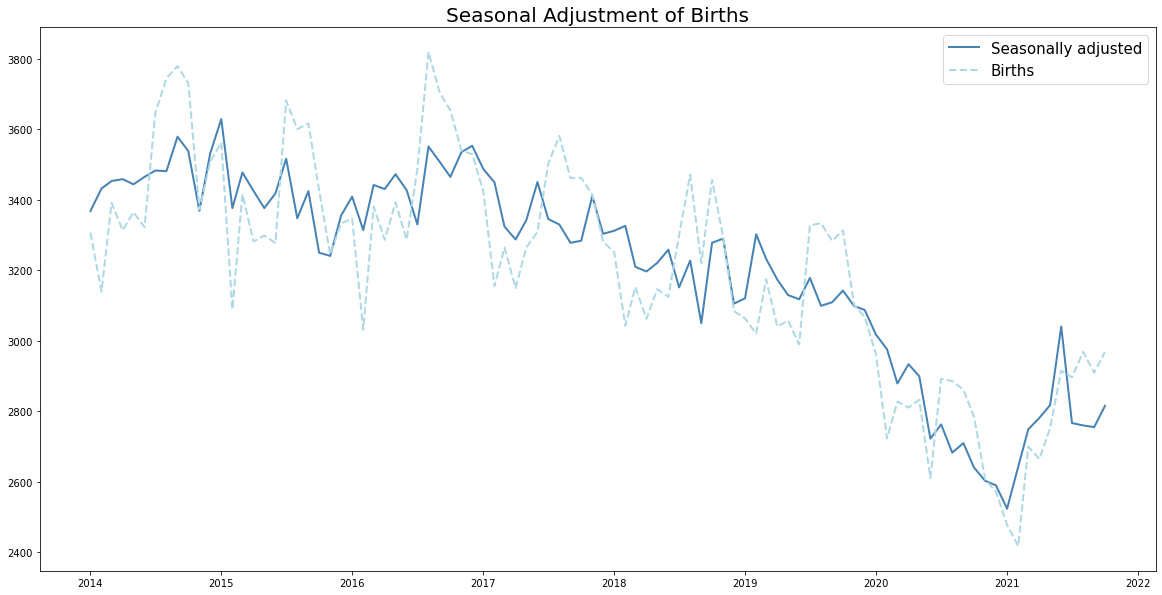

In [19]:
sa_births = sm.tsa.seasonal_decompose(oc_df.births, model = 'multiplicative')

# Extract the trend and seasonal components
births_trend = sa_births.trend
births_seasonal = sa_births.seasonal

# Construct the seasonally adjusted series
births_adjusted = (oc_df.births / sa_births.seasonal).rename('sa_births')

# Plot
fig = plt.figure(figsize = (20, 10))
plt.plot(births_adjusted, c = 'steelblue', label = 'Seasonally adjusted', linewidth = 2)
plt.plot(oc_df['births'], c = 'lightblue', label = 'Births', linewidth = 2, linestyle = '--')
plt.title('Seasonal Adjustment of Births', fontsize = 20)
plt.legend(fontsize = 15)

# Save figure into the results folder
plt.savefig(os.path.join(RESULTS_PATH, 'births_seasonal-adjustment.jpg'))

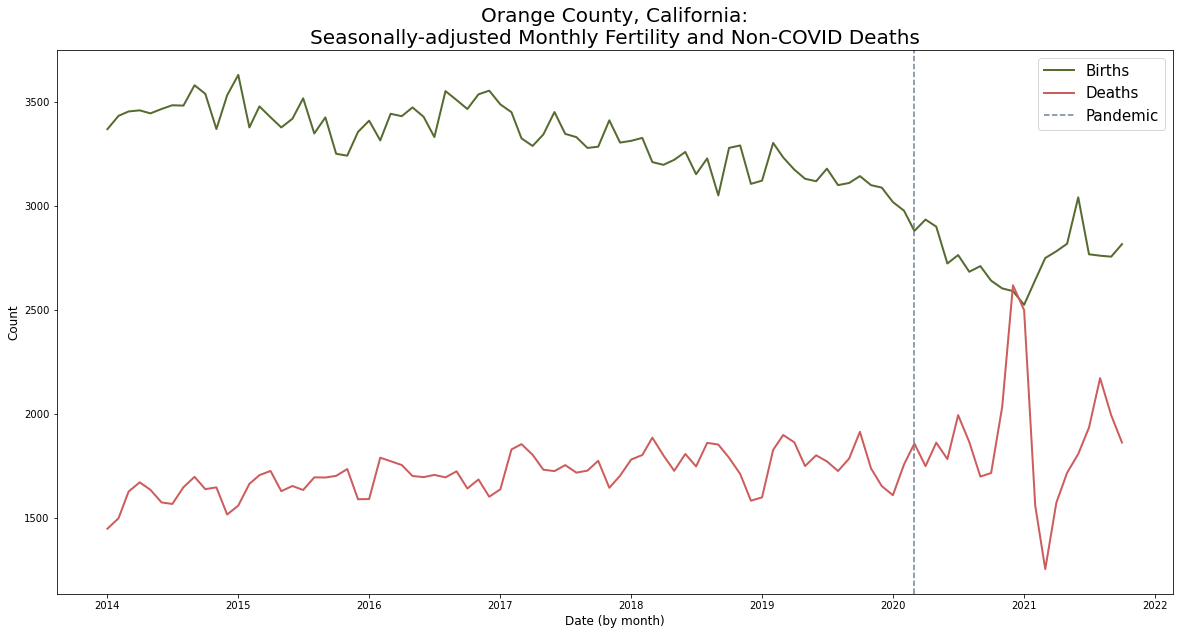

In [20]:
oc_df['sa_deaths'] = deaths_adjusted
oc_df['sa_births'] = births_adjusted

# Redo earlier plot
fig = plt.figure(figsize = (20, 10))
plt.plot(oc_df['sa_births'], label = 'Births', c = 'darkolivegreen', linewidth = 2)
plt.plot(oc_df['sa_deaths'], label = 'Deaths', c = 'indianred', linewidth = 2)
plt.axvline(x=pd.to_datetime('2020/03/01', format='%Y/%m/%d'), c = 'slategray', linestyle = '--', label = 'Pandemic')
plt.xlabel('Date (by month)', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.title('Orange County, California:\nSeasonally-adjusted Monthly Fertility and Non-COVID Deaths', fontsize = 20)
plt.legend(fontsize = 15)

# Save figure into the results folder
plt.savefig(os.path.join(RESULTS_PATH, 'oc_adjusted_fertility-non-covid-deaths.jpg'))

### Suicides and Accidents  
There did not seem to be seasonality associated with accidents and suicides.

In [21]:
# sa_accidents = sm.tsa.seasonal_decompose(oc_df['accidents'].loc[oc_df['accidents'].notna()], model='multiplicative')
# sa_suicide = sm.tsa.seasonal_decompose(oc_df['suicide'].loc[oc_df['suicide'].notna()], model='multiplicative')
# # Construct the seasonally adjusted series
# accidents_adjusted = (oc_df.accidents / sa_accidents.seasonal).rename('sa_accidents')
# suicides_adjusted = (oc_df.suicide / sa_suicide.seasonal).rename('sa_suicides')

# oc_df['sa_accidents'] = accidents_adjusted
# oc_df['sa_suicide'] = suicides_adjusted

# # Plot
# fig = plt.figure(figsize = (20, 10))
# plt.plot(oc_df['sa_accidents'], label = 'Accidents', c = 'steelblue', linewidth = 2)
# plt.plot(oc_df['accidents'], label = 'Accidents', c = 'lightblue', linewidth = 2, linestyle = '--')
# plt.plot(oc_df['sa_suicide'], label = 'Suicides', c = 'forestgreen', linewidth = 2)
# plt.plot(oc_df['sa_suicide'], label = 'Suicides', c = 'lightgreen', linewidth = 2, linestyle = '--')
# plt.axvline(x=pd.to_datetime('2020/03/01', format='%Y/%m/%d'), c = 'slategray', linestyle = '--', label = 'Pandemic')
# plt.xlabel('Date (by month)', fontsize = 12)
# plt.ylabel('Count', fontsize = 12)
# plt.title('Orange County, California:\nSeasonally-Adjusted Deaths by Cause', fontsize = 20)
# plt.legend(fontsize = 15)

# # Save figure into the results folder
# plt.savefig(os.path.join(RESULTS_PATH, 'oc_sa_accidents-suicide.jpg'))